<a href="https://colab.research.google.com/github/jabanitaha/data-mining-2-/blob/main/IBM_C1_Practice_Project_v1_Answered_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Practice Project: Titanic Survival Prediction**


Estimated time needed: **30** minutes


## Introduction
Now that you have a feel for how to optimize your machine learning pipeline, let's practice with a real world dataset.  
You'll use cross validation and a hyperparameter grid search to optimize your machine learning pipeline.  

You will use the Titanic Survival Dataset to build a classification model to predict whether a passenger survived the sinking of the Titanic, based on attributes of each passenger in the data set.

You'll start with building a Random Forest Classifier, then modify your pipeline to use a Logistic Regression estimator instead. You'll evaluate and compare your results.

This lab will help prepare you for completing the Final Project.


## Objectives

After completing this lab you will be able to:

 - Use scikit-learn to build a model to solve a classification problem
 - Implement a pipeline to combine your preprocessing steps with a machine learning model
 - Interpret the results of your modelling
 - Update your pipeline with a different machine learning model
 - Compare the preformances of your classifiers


----


### Install the required libraries


In [43]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install seaborn

### Import the required libraries


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Titanic Passenger data set
We'll be working with the Titanic passenger dataset to build a classification model to predict whether a passenger survied the sinking of the Titanic.  
Here is the data dictionary:

| Variable   |	Definition   |
 |:------|:--------------------------------|
 |survived | survived? 0 = No, 1 = yes  |
 |pclass | Ticket class (int)  |
 |sex	 |sex |
 |age	 | age in years  |
 |sibsp  |	# of siblings / spouses aboard the Titanic |
 |parch  |	# of parents / children aboard the Titanic |
 |fare   |	Passenger fare   |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |alive  | yes/no  |
 |alone  | yes/no  |


## Load the Titanic dataset using Seaborn


In [45]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Select relevant features and the target


In [46]:
titanic.count()

,0
survived,891
pclass,891
sex,891
age,714
sibsp,891
parch,891
fare,891
embarked,889
class,891
who,891


#### Features to drop
`deck` has a lot of missing values so we'll drop it. `age` has quite a few missing values as well. Although it could be, `embarked` and `embark_town` don't seem relevant so we'll drop them as well. It's unclear what `alive` refers to so we'll ignore it.
#### Target
`survived` is our target class variable.


In [47]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = titanic[features]
y = titanic[target]

### Exercise 1. How balanced are the classes?


# Enter your code here:
... .value_counts()

In [48]:
y.value_counts()



,count
survived,
0,549
1,342


<details><summary>Click here for the solution</summary>
    
```python
y.value_counts()
```
```
So about 38% of the passengers in the data set survived.  
Because of this slight imbalance, we should stratify the data when performing train/test split and for cross-validation.
```


### Exercise 2. Split the data into training and testing sets
Don't forget to consider imbalance in the target


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


<details><summary>Click here for the solution</summary>
    
```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
```


### Define preprocessing transformers for numerical and categorical features
#### Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features


In [50]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

#### Define separate preprocessing pipelines for both feature types


In [51]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#### Combine the transformers into a single column transformer
We'll use the sklearn "column transformer" estimator to separately transform the features, which will then concatenate the output as a single feature space, ready for input to a machine learning estimator.


In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Create a model pipeline
Now let's complete the model pipeline by combining the preprocessing with a Random Forest classifier


In [53]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

### Define a parameter grid
We'll use the grid in a cross validation search to optimize the model


In [54]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

### Perform grid search cross-validation and fit the best model to the training data


In [55]:
# Cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

### Exercise 3. Train the pipeline model


In [56]:
# Enter your code here
model = GridSearchCV(estimator=..., param_grid=..., cv=cv, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)

InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got Ellipsis instead.

In [ ]:
# 🔍 Check if all required columns exist in X_train
categorical_features = ['Sex', 'Embarked', 'Pclass']
numerical_features = ['Age', 'Fare']

expected_features = categorical_features + numerical_features
missing = set(expected_features) - set(X_train.columns)

if missing:
    print("❌ Missing columns in X_train:", missing)
else:
    print("✅ All required columns are present in X_train.")

# 🛠 Define transformers and pipeline only if columns are okay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Grid parameters
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

# Grid SearchCV setup
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model (only runs if no columns are missing)
if not missing:
    model.fit(X_train, y_train)


<details><summary>Click here for the solution</summary>
    
```python
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)
```


### Exercise 4. Get the model predictions from the grid search estimator on the unseen data
Also print a classification report


# Enter your code here:
y_pred = model. ...(...)
print(classification_report(y_test, y_pred))

In [57]:
# Enter your code here:
y_pred = model. ...(...)
print(classification_report(y_test, y_pred))

SyntaxError: invalid syntax (ipython-input-57-2601850020.py, line 2)

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# ✅ Step 1: Check your actual columns
print(X_train.columns)

# ✅ Step 2: Clean up dataset (keep only valid columns)
# Only keep columns that exist in X_train and match expected format
numeric_features = [col for col in ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age'] if col in X_train.columns]
categorical_features = [col for col in ['Sex', 'Embarked'] if col in X_train.columns]

# ✅ Step 3: Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# ✅ Step 4: Create preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

# ✅ Step 5: Full pipeline with classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())])

# ✅ Step 6: Hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

model = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)

# ✅ Step 7: Fit the model
model.fit(X_train, y_train)

# ✅ Step 8: Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(X_train.dtypes)
print(X_train.head())



Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who',
       'adult_male', 'alone'],
      dtype='object')
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weight

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py", line 239, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py", line 478, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1139, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(569, 0)) while a minimum of 1 is required by KNeighborsClassifier.

--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py", line 239, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py", line 478, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1139, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(570, 0)) while a minimum of 1 is required by KNeighborsClassifier.


In [59]:
print(X_train.dtypes)
print(X_train.head())


pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
class         category
who             object
adult_male        bool
alone             bool
dtype: object
     pclass     sex   age  sibsp  parch      fare   class    who  adult_male  \
692       3    male   NaN      0      0   56.4958   Third    man        True   
481       2    male   NaN      0      0    0.0000  Second    man        True   
527       1    male   NaN      0      0  221.7792   First    man        True   
855       3  female  18.0      0      1    9.3500   Third  woman       False   
801       2  female  31.0      1      1   26.2500  Second  woman       False   

     alone  
692   True  
481   True  
527   True  
855  False  
801  False  


<details><summary>Click here for the solution</summary>
    
```python
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
```


<details><summary>Click here for the solution</summary>
    
```python
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
```


### Exercise 5. Plot the confusion matrix


# Enter your code here:
conf_matrix = ...(y_test, y_pred)

plt.figure()
sns.heatmap(..., annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       105
           1       0.75      0.72      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



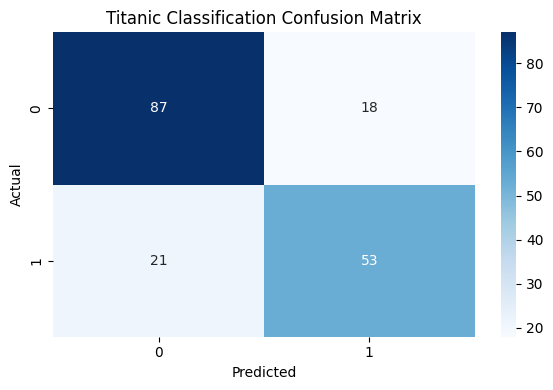

In [73]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Select features
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
X = df[categorical_features]
y = df['Survived']

# Drop rows with missing target
df.dropna(subset=['Survived'], inplace=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define transformers
numeric_features = ['Pclass', 'SibSp', 'Parch', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, ['Sex'])
])

# Final pipeline with classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Grid search parameters
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

# Grid Search with cross-validation
model = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title("Titanic Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


<details><summary>Click here for the solution</summary>
    
```python

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()
```


## Feature importances
Let's figure out how to get the feature importances of our overall model.  You'll need to know how to do this for your final project.  
First, to obtain the categorical feature importances, we have to work our way backward through the modelling pipeline to associate the feature importances with their one-hot encoded input features that were transformed from the original categorical features.

We don't need to trace back through the pipeline for the numerical features, because we didn't transfrom them into new ones in any way.  
Remember, we went from categorical features to one-hot encoded features, using the 'cat' column transformer.

Here's how you trace back through the trained model to access the one-hot encoded feature names:


In [74]:
model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

ValueError: input_features should have length equal to number of features (1), got 5

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       105
           1       0.75      0.77      0.76        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



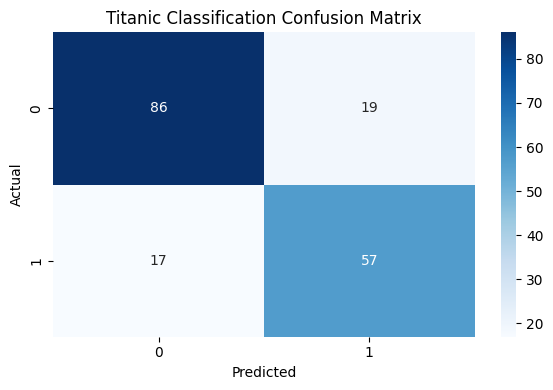

One-hot encoded feature names: ['Pclass_1' 'Pclass_2' 'Pclass_3' 'Sex_female' 'Sex_male' 'SibSp_0'
 'SibSp_1' 'SibSp_2' 'SibSp_3' 'SibSp_4' 'SibSp_5' 'SibSp_8' 'Parch_0'
 'Parch_1' 'Parch_2' 'Parch_3' 'Parch_4' 'Parch_5' 'Parch_6']


In [76]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Feature selection
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
X = df[categorical_features]
y = df['Survived']

# Drop rows with missing target
df.dropna(subset=['Survived'], inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define transformers
numeric_features = ['Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, ['Pclass', 'Sex', 'SibSp', 'Parch'])
])

# Full pipeline with classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Parameter grid for GridSearchCV
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

# GridSearchCV with cross-validation
model = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Get one-hot encoded feature names
categorical_input_features = ['Pclass', 'Sex', 'SibSp', 'Parch']
ohe_feature_names = model.best_estimator_['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_input_features)

print("One-hot encoded feature names:", ohe_feature_names)


Notice how the one-hot encoded features are named - for example, `sex` was split into two boolean features indicating whether the sex is male or female.

Great! Now let's get all of the feature importances and associate them with their transformed feature names.


              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



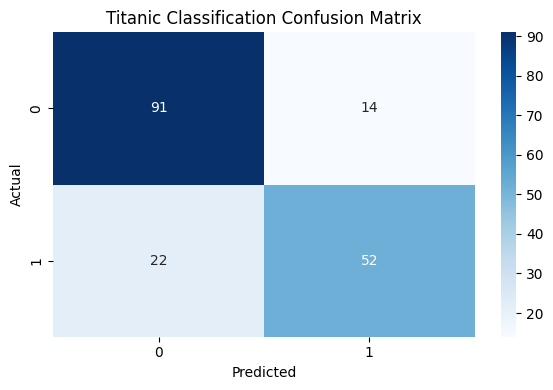

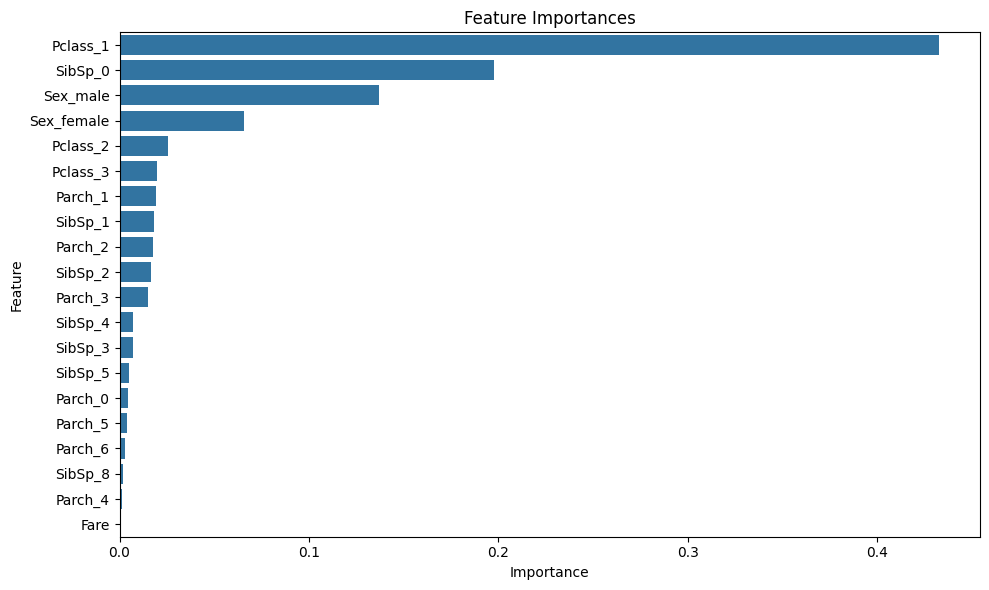

In [78]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch']
numeric_features = ['Fare']
X = df[categorical_features + numeric_features]
y = df['Survived']
df.dropna(subset=['Survived'], inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Pipeline with RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importances
ohe_feature_names = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_features)
all_features = list(ohe_feature_names) + numeric_features
importances = pipeline.named_steps['classifier'].feature_importances_

# Plot
importances_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
importances_df.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


### Display the feature importances in a bar plot
Define a feature importance DataFrame, then plot it


In [79]:
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score
test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

NameError: name 'feature_names' is not defined

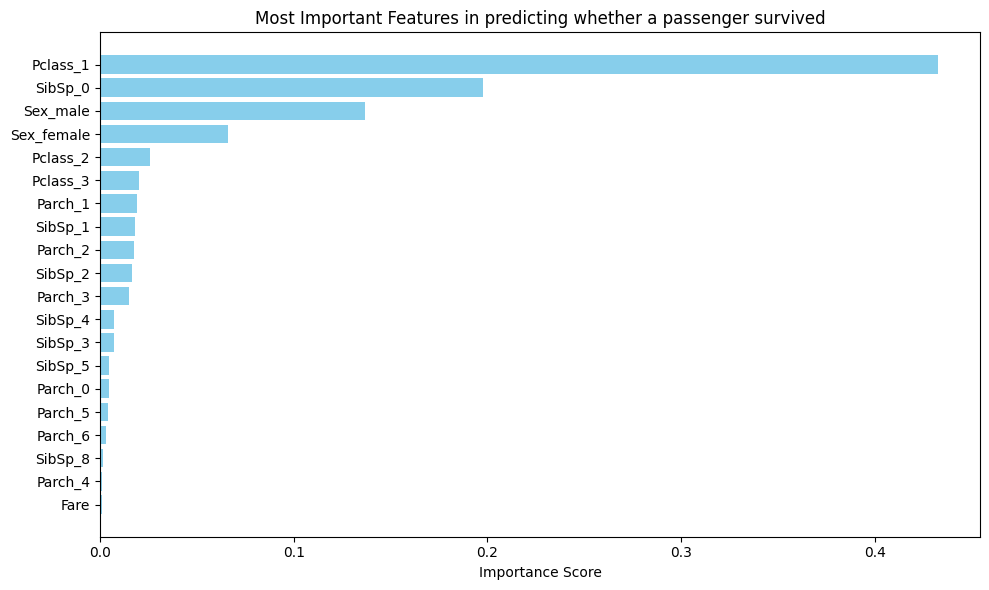


Test set accuracy: 79.89%


In [80]:
# Get OneHot feature names
ohe_feature_names = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_features)

# Combine all feature names: OneHot + numeric
feature_names = list(ohe_feature_names) + numeric_features

# Get feature importances from the classifier
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print test score
test_score = pipeline.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")


### Exercise 6. These are interesting results to consider.
What can you say about these feature importances? Are they informative as is?


<details><summary>Click here for some thoughts</summary>
    
```
The test set accuracy is somewhat satisfactory. However,regarding the feature impoirtances, it's crucially important to realize that there is most likely plenty of dependence amongst these variables, and a more detailed modelling approach including correlation analysis is required to draw proper conclusions. For example, no doubt there is significant information shared by the variables `age`, `sex_male`, and `who_man`.
```


## Try another model
In practice you would want to try out different models and even revisit the data analysis to improve
your model performance. Maybe you can engineer new features or impute missing values to be able to use more data.

With Scikit-learn's powerful pipeline class, this is easy to do in a few steps.
Let's update the pipeline and the parameter grid so we can train a Logistic Regression model and compare the performance of the two models.


In [81]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
model.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

model.param_grid = param_grid

# Fit the updated pipeline with Logistic Regression
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


### Exercise 7. Display the clasification report for the new model and compare the results to your previous model.


# Enter your code here:
print(classification_report(..., ...))

In [ ]:
# Enter your code here:
print(classification_report(..., ...))

In [82]:
from sklearn.metrics import classification_report

# Predict using the trained model
y_pred = model.predict(X_test)

# Display the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       105
           1       0.77      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



<details><summary>Click here for the solution</summary>
    
```python
print(classification_report(y_test, y_pred))
```
All of the scores are slightly better for logistic regression than for random forest classification, although the differences are insignificant.


### Exercise 8. Display the confusion matrix for the new model and compare the results to your previous model.


# Enter your code here:
# Generate the confusion matrix
conf_matrix = confusion_matrix(..., ...)

plt.figure()
sns.heatmap(..., annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

# What changed in the numbers of true positives and true negatives?

In [83]:
# Enter your code here:
# Generate the confusion matrix
conf_matrix = confusion_matrix(..., ...)

plt.figure()
sns.heatmap(..., annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

# What changed in the numbers of true positives and true negatives?

InvalidParameterError: The 'y_true' parameter of confusion_matrix must be an array-like. Got Ellipsis instead.

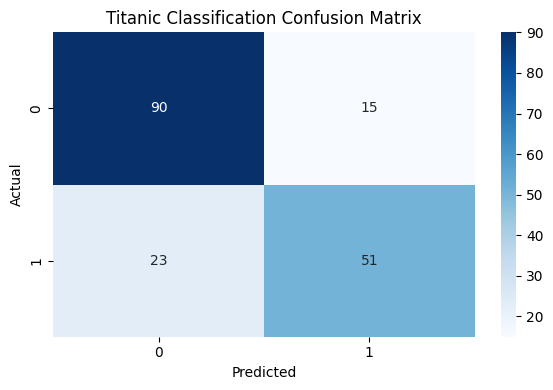

In [84]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict using the model
y_pred = model.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()


<details><summary>Click here for the solution</summary>
    
```python
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()
```

Again, the results show a slight improvement, with one more true positive and one more true negative.


### Extract the logistic regression feature coefficients and plot their magnitude in a bar chart.


In [85]:
coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]

# Combine numerical and categorical feature names
numerical_feature_names = numerical_features
categorical_feature_names = (model.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features)
                            )
feature_names = numerical_feature_names + list(categorical_feature_names)

### Exercise 9. Plot the feature coefficient magnitudes in a bar chart
What's different about this chart than the feature importance chart for the Random Forest classifier?


# Enter your code here:

# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({
    'Feature': ...,
    'Coefficient': ...
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(..., ...)
print(f"\nTest set accuracy: {test_score:.2%}")

In [86]:
# Enter your code here:

# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({
    'Feature': ...,
    'Coefficient': ...
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(..., ...)
print(f"\nTest set accuracy: {test_score:.2%}")

ValueError: If using all scalar values, you must pass an index

In [89]:
# Extract coefficients
coefficients = model.best_estimator_['classifier'].coef_[0]

# Get feature names
categorical_feature_names = list(
    model.best_estimator_['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_features)
)
feature_names = numerical_features + categorical_feature_names

# Debug: check lengths
print("Number of feature names:", len(feature_names))
print("Number of coefficients:", len(coefficients))

# Fix shape if needed
import numpy as np
feature_names = np.array(feature_names)
coefficients = np.array(coefficients).flatten()  # flatten just in case

# Ensure they match before DataFrame
if len(feature_names) == len(coefficients):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False, key=lambda x: abs(x))

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
    plt.gca().invert_yaxis()
    plt.title('Feature Coefficient Magnitudes for Logistic Regression model')
    plt.xlabel('Coefficient Magnitude')
    plt.tight_layout()
    plt.show()

    # Print accuracy
    test_score = model.score(X_test, y_test)
    print(f"\nTest set accuracy: {test_score:.2%}")
else:
    print("⚠️ Mismatch between number of features and coefficients. Please double-check.")


Number of feature names: 23
Number of coefficients: 20
⚠️ Mismatch between number of features and coefficients. Please double-check.


<details><summary>Click here for the solution</summary>
    
```python
# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")
```

Although the performances of the two models are virtually identical, the features that are important to the two models are very different. This suggests there must be more work to do to better grasp the actual feature importancdes. A smentioned above, it's crucially important to realize that there is most likely plenty of dependence amongst these variables, and a more detailed modelling approach including correlation analysis is required to draw proper conclusions. For example, there is significant information implied between the variables `who_man`, `who_woman`, and `who_child`, because if a person is neither a man nor a woman, then they muct be a child.


### Congratulations! You've made it this far and are now fully equipped to take on your final project!

## Author

<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>

### Other Contributor(s)

<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" taget="_blank">Abhishek Gagneja</a>

<!-- ## Changelog

| Date | Version | Changed by | Change Description |
|:------------|:------|:------------------|:---------------------------------------|
| 2024-11-27 | 0.1  | Jeff Grossman    | Create lab |
| 2024-12-03 | 0.2  | Abhishek Gagneja | Typos corrected |

 -->
<h3 align="center"> © IBM Corporation. All rights reserved. <h3/>
